In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

#set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,8)

print("All libraries loaded successfully!")
print("Project : portfolio Risk Assessment & Var calculation")
print("="*60)
%matplotlib inline 

All libraries loaded successfully!
Project : portfolio Risk Assessment & Var calculation


In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
import datetime as dt
from pandas_datareader import data as pdr

# 1. data collection and setup

# define portfolio and data range
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']    # example equities
weights = np.array([0.25, 0.25, 0.25, 0.25])   # equal-weight portfolio

start = dt.datetime(2023, 1, 1)
end = dt.datetime.today()

# container for adjusted close prices
prices = pd.DataFrame(index=pd.date_range(start, end))

for ticker in tickers:
    print(f"Fetching {ticker} -", end=" ")
    try:
        # pull via yfinance
        df = yf.Ticker(ticker).history(
            start=start.strftime('%Y-%m-%d'),
            end=end.strftime('%Y-%m-%d'),
            auto_adjust=True,
        )
        series = df['Close']
        print("right yfinance", end=" ")
    except Exception as e:
        # fallback to stooq if yfinance fails
        print(f"wrong yfinance ({e}); falling back to stooq", end=" ")
        df2 = pdr.DataReader(ticker, 'stooq', start, end)
        df2 = df2.sort_index()
        series = df2['Close']
    
    # align on master date index
    prices[ticker] = series
    time.sleep(1)  # pause for rate limits
    print()

# clean data: drop all-NaN rows, forward/back fill gaps
prices = prices.dropna(how='all').ffill().bfill()

# quick sanity check
print(prices.tail())


Fetching AAPL - right yfinance 
Fetching MSFT - right yfinance 
Fetching GOOGL - right yfinance 
Fetching AMZN - right yfinance 
Empty DataFrame
Columns: [AAPL, MSFT, GOOGL, AMZN]
Index: []


In [17]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
data = yf.download(tickers, start='2020-01-01', end='2021-01-01')['Close']
prices = data.dropna()
prices.head()

C:\Users\thaku\AppData\Local\Temp\ipykernel_10160\4157209843.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2020-01-01', end='2021-01-01')['Close']
[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2020-01-02,72.538506,94.900497,68.026024,152.791107
2020-01-03,71.833298,93.748497,67.670151,150.888626
2020-01-06,72.405670,95.143997,69.473846,151.278656
2020-01-07,72.065163,95.343002,69.339645,149.899323
2020-01-08,73.224403,94.598503,69.833191,152.286972


In [18]:
# log-return = ln(p_t / p_{t-1})
log_returns = np.log(data / data.shift(1)).dropna()
print(log_returns.head())


Ticker          AAPL      AMZN     GOOGL      MSFT
Date                                              
2020-01-03 -0.009769 -0.012213 -0.005245 -0.012530
2020-01-06  0.007936  0.014776  0.026305  0.002582
2020-01-07 -0.004714  0.002089 -0.001934 -0.009160
2020-01-08  0.015958 -0.007839  0.007093  0.015803
2020-01-09  0.021018  0.004788  0.010443  0.012416


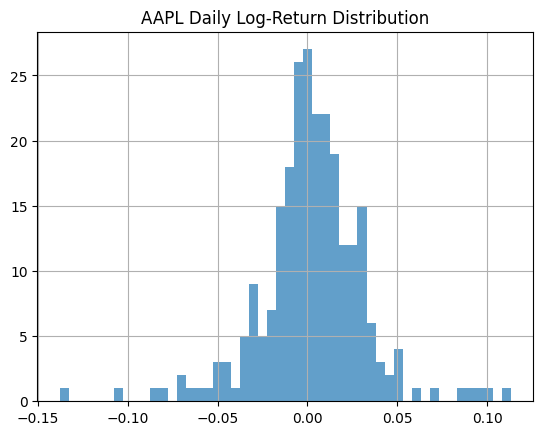

In [19]:
#plot one example series for visual check
#you'll see a bell-shaped histogram
log_returns['AAPL'].hist(bins=50, alpha=0.7)
plt.title('AAPL Daily Log-Return Distribution')
plt.show()

In [20]:
summary_stats = pd.DataFrame({
    'Mean':     log_returns.mean(),
    'Variance': log_returns.var(),
    'Skewness': log_returns.skew(),
    'Kurtosis': log_returns.kurtosis()
})
summary_stats

print("summary statistic table:")
print(summary_stats.round(6))

summary statistic table:
            Mean  Variance  Skewness  Kurtosis
Ticker                                        
AAPL    0.002293  0.000866 -0.303352  3.919266
AMZN    0.002143  0.000586 -0.018777  1.271710
GOOGL   0.000981  0.000592 -0.476708  4.314470
MSFT    0.001334  0.000770 -0.420855  6.930785


In [21]:
# 5. portfolio returns calculation

print("\n" + "="*60)
print("STEP-5 PORTFOLIO RETURNS CALCULATION")
print("="*60)

# calculate portfolio returns using equal weights
portfolio_returns = (log_returns * weights).sum(axis=1)
print(f"portfolio returns shape: {portfolio_returns.shape}")
print(f"portfolio average daily returns : {portfolio_returns.mean():.6f}")
print(f"portfolio daily volatiity: {portfolio_returns.std():.6f}")




STEP-5 PORTFOLIO RETURNS CALCULATION
portfolio returns shape: (252,)
portfolio average daily returns : 0.001688
portfolio daily volatiity: 0.024028


In [22]:
# ============================
# Step 6: Fitting Normal Distribution
# ============================

print("\n" + "="*60)
print("STEP 6: FITTING NORMAL DISTRIBUTION")
print("="*60)

# Combine all returns for distribution fitting
all_returns = log_returns.values.flatten()
all_returns = all_returns[~np.isnan(all_returns)]

# Fit normal distribution
mu_normal, sigma_normal = stats.norm.fit(all_returns)

print(f"Normal Distribution Parameters:")
print(f"Mean (μ): {mu_normal:.6f}")
print(f"Standard Deviation (σ): {sigma_normal:.6f}")

# Calculate 95% confidence intervals for normal distribution
n = len(all_returns)
se_mean = sigma_normal / np.sqrt(n)
ci_mean_normal = stats.norm.interval(0.95, mu_normal, se_mean)

# CI for standard deviation using chi-square
chi2_lower = stats.chi2.ppf(0.025, n-1)
chi2_upper = stats.chi2.ppf(0.975, n-1)
ci_sigma_lower = np.sqrt((n-1) * sigma_normal**2 / chi2_upper)
ci_sigma_upper = np.sqrt((n-1) * sigma_normal**2 / chi2_lower)

print(f"\n95% Confidence Intervals:")
print(f"Mean CI: [{ci_mean_normal[0]:.6f}, {ci_mean_normal[1]:.6f}]")
print(f"Std Dev CI: [{ci_sigma_lower:.6f}, {ci_sigma_upper:.6f}]")





STEP 6: FITTING NORMAL DISTRIBUTION
Normal Distribution Parameters:
Mean (μ): 0.001688
Standard Deviation (σ): 0.026475

95% Confidence Intervals:
Mean CI: [0.000053, 0.003322]
Std Dev CI: [0.025368, 0.027685]


In [24]:
# ============================
# Step 7: Fitting Student's t-Distribution
# ============================

print("\n" + "="*60)
print("STEP 7: FITTING STUDENT'S T-DISTRIBUTION")
print("="*60)

# Fit t-distribution
df_t, mu_t, sigma_t = stats.t.fit(all_returns)

print(f"Student's t-Distribution Parameters:")
print(f"Degrees of Freedom (df): {df_t:.2f}")
print(f"Location (μ): {mu_t:.6f}")
print(f"Scale (σ): {sigma_t:.6f}")



STEP 7: FITTING STUDENT'S T-DISTRIBUTION
Student's t-Distribution Parameters:
Degrees of Freedom (df): 2.92
Location (μ): 0.002375
Scale (σ): 0.016696


In [27]:
# ============================
# Step 8: Bootstrap Confidence Intervals (Fast Version)
# ============================

print("\n" + "="*60)
print("STEP 8: BOOTSTRAP CONFIDENCE INTERVALS (FAST VERSION)")
print("="*60)

# Bootstrap sampling
n_bootstrap = 500   # reduced for speed but still reliable
bootstrap_means = []
bootstrap_stds = []

np.random.seed(42)
for i in range(n_bootstrap):
    # Resample with replacement
    bootstrap_sample = np.random.choice(all_returns, size=len(all_returns), replace=True)
    
    # Instead of fitting t-distribution (slow), directly compute mean & std
    mu_boot = np.mean(bootstrap_sample)
    sigma_boot = np.std(bootstrap_sample, ddof=1)
    
    bootstrap_means.append(mu_boot)
    bootstrap_stds.append(sigma_boot)

# Calculate 95% confidence intervals
bootstrap_mean_ci = np.percentile(bootstrap_means, [2.5, 97.5])
bootstrap_std_ci = np.percentile(bootstrap_stds, [2.5, 97.5])

print(f"Bootstrap 95% Confidence Intervals (n={n_bootstrap}):")
print(f"Mean CI: [{bootstrap_mean_ci[0]:.6f}, {bootstrap_mean_ci[1]:.6f}]")
print(f"Std Dev CI: [{bootstrap_std_ci[0]:.6f}, {bootstrap_std_ci[1]:.6f}]")



STEP 8: BOOTSTRAP CONFIDENCE INTERVALS (FAST VERSION)
Bootstrap 95% Confidence Intervals (n=500):
Mean CI: [-0.000003, 0.003364]
Std Dev CI: [0.024344, 0.028423]


In [28]:
# ============================
# Step 9: Value at Risk (VaR) Calculations
# ============================

print("\n" + "="*60)
print("STEP 9: VALUE AT RISK (VaR) CALCULATIONS")
print("="*60)

# Portfolio statistics
portfolio_mean = portfolio_returns.mean()
portfolio_std = portfolio_returns.std()

print(f"Portfolio Statistics:")
print(f"Mean daily return: {portfolio_mean:.6f}")
print(f"Daily volatility: {portfolio_std:.6f}")

# 1. Normal Distribution VaR
confidence_level = 0.95
z_score = stats.norm.ppf(1 - confidence_level)  # -1.645 for 95%
var_normal = -(portfolio_mean + portfolio_std * z_score)

print(f"\n1. Normal Distribution VaR (95%):")
print(f"Z-score: {z_score:.4f}")
print(f"VaR: {var_normal:.6f} ({var_normal*100:.2f}%)")

# 2. Student's t-Distribution VaR
df_portfolio, mu_portfolio, sigma_portfolio = stats.t.fit(portfolio_returns)
t_score = stats.t.ppf(1 - confidence_level, df_portfolio)
var_t = -(mu_portfolio + sigma_portfolio * t_score)

print(f"\n2. Student's t-Distribution VaR (95%):")
print(f"Degrees of freedom: {df_portfolio:.2f}")
print(f"t-score: {t_score:.4f}")
print(f"VaR: {var_t:.6f} ({var_t*100:.2f}%)")

# 3. Historical VaR
var_historical = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)

print(f"\n3. Historical VaR (95%):")
print(f"VaR: {var_historical:.6f} ({var_historical*100:.2f}%)")


STEP 9: VALUE AT RISK (VaR) CALCULATIONS
Portfolio Statistics:
Mean daily return: 0.001688
Daily volatility: 0.024028

1. Normal Distribution VaR (95%):
Z-score: -1.6449
VaR: 0.037835 (3.78%)

2. Student's t-Distribution VaR (95%):
Degrees of freedom: 2.56
t-score: -2.5265
VaR: 0.032449 (3.24%)

3. Historical VaR (95%):
VaR: 0.039849 (3.98%)


In [29]:
# ============================
# Step 10: Expected Shortfall (Conditional VaR)
# ============================

print("\n" + "="*60)
print("STEP 10: EXPECTED SHORTFALL CALCULATIONS")
print("="*60)

# Historical Expected Shortfall
threshold = np.percentile(portfolio_returns, 5)
tail_returns = portfolio_returns[portfolio_returns <= threshold]
es_historical = -tail_returns.mean()

print(f"Historical Expected Shortfall (95%):")
print(f"ES: {es_historical:.6f} ({es_historical*100:.2f}%)")

# Parametric Expected Shortfall (Normal)
phi = stats.norm.pdf(z_score)
es_normal = portfolio_std * phi / (1 - confidence_level) - portfolio_mean

print(f"\nParametric Expected Shortfall - Normal (95%):")
print(f"ES: {es_normal:.6f} ({es_normal*100:.2f}%)")



STEP 10: EXPECTED SHORTFALL CALCULATIONS
Historical Expected Shortfall (95%):
ES: 0.058308 (5.83%)

Parametric Expected Shortfall - Normal (95%):
ES: 0.047875 (4.79%)



STEP 11: CORRELATION ANALYSIS
Correlation Matrix:
Ticker   AAPL   AMZN  GOOGL   MSFT
Ticker                            
AAPL    1.000  0.703  0.759  0.844
AMZN    0.703  1.000  0.678  0.741
GOOGL   0.759  0.678  1.000  0.862
MSFT    0.844  0.741  0.862  1.000


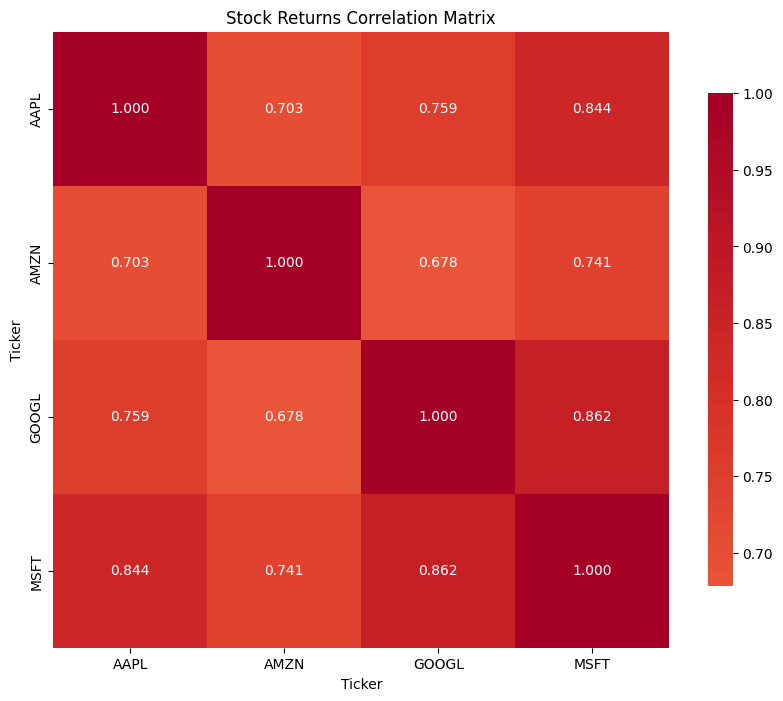


Diversification Analysis:
Weighted average individual risk: 0.013261
Actual portfolio risk: 0.024028
Diversification benefit: -0.010767


In [33]:
# ============================
# Step 11: Correlation Analysis and Diversification
# ============================

print("\n" + "="*60)
print("STEP 11: CORRELATION ANALYSIS")
print("="*60)

# Calculate correlation matrix
correlation_matrix = log_returns.corr()
print("Correlation Matrix:")
print(correlation_matrix.round(3))

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": 0.8})
plt.title('Stock Returns Correlation Matrix')
plt.show()

# Diversification benefit analysis
individual_stds = log_returns.std()
weighted_avg_risk = np.sqrt(np.sum((np.array(weights) * individual_stds) ** 2))
actual_portfolio_risk = portfolio_std
diversification_benefit = weighted_avg_risk - actual_portfolio_risk

print(f"\nDiversification Analysis:")
print(f"Weighted average individual risk: {weighted_avg_risk:.6f}")
print(f"Actual portfolio risk: {actual_portfolio_risk:.6f}")
print(f"Diversification benefit: {diversification_benefit:.6f}")


STEP 12: DRAWDOWN ANALYSIS
Maximum Drawdown: -0.2834 (-28.34%)
Max Drawdown Date: 2020-03-16


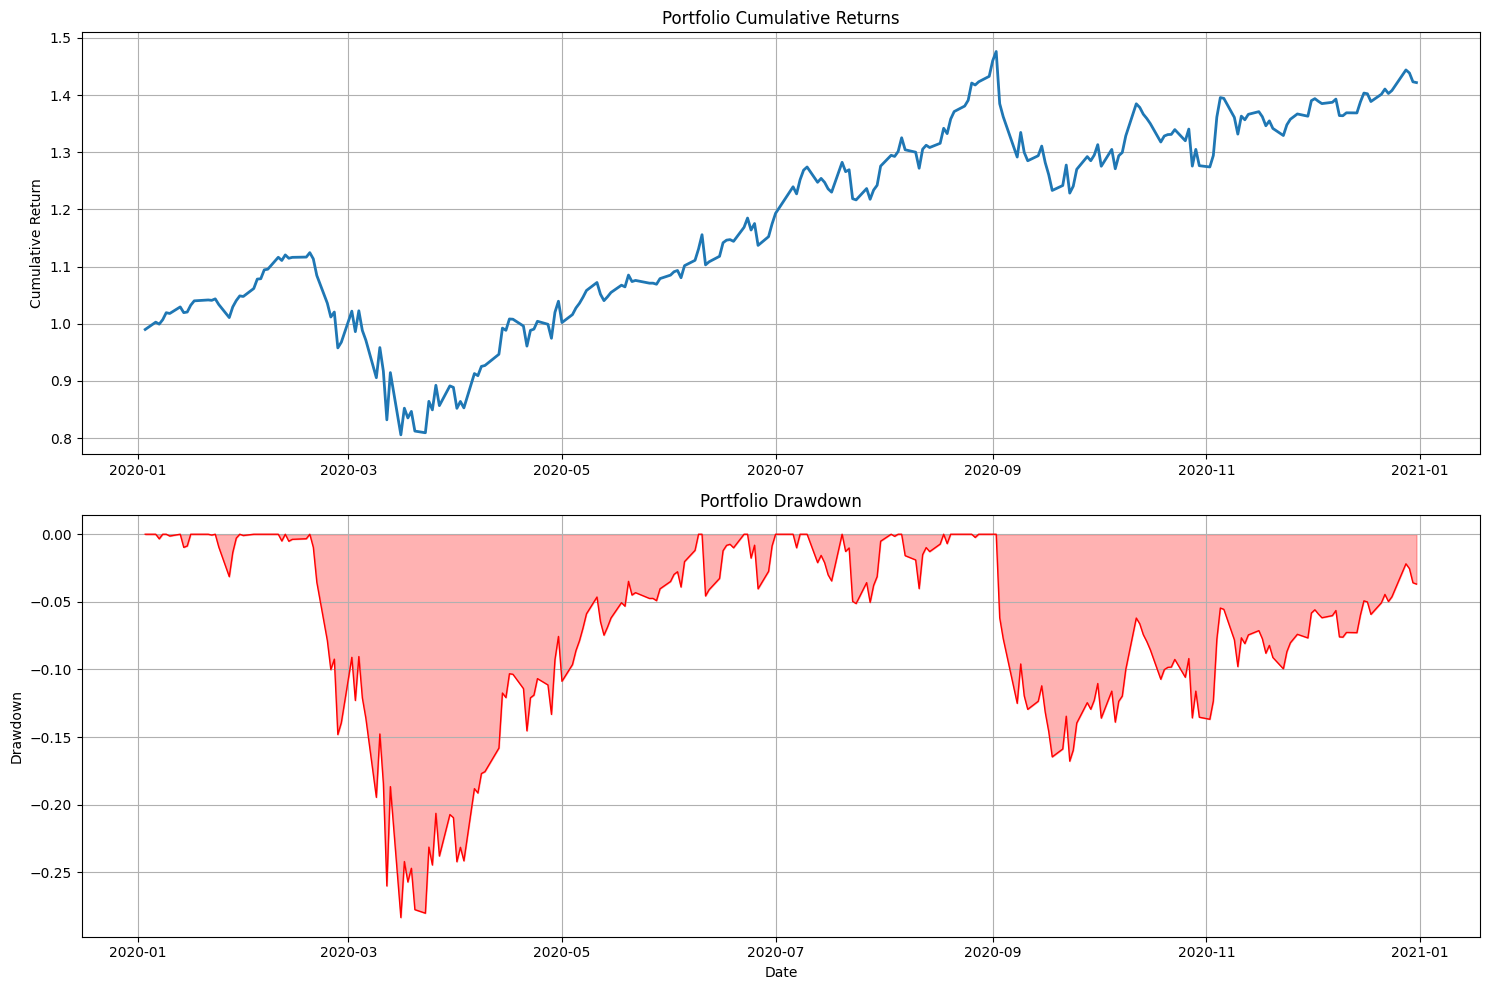

In [31]:
# ============================
# Step 12: Portfolio Growth and Drawdown Analysis
# ============================

print("\n" + "="*60)
print("STEP 12: DRAWDOWN ANALYSIS")
print("="*60)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Calculate running maximum (peaks)
running_max = cumulative_returns.expanding().max()

# Calculate drawdown
drawdown = (cumulative_returns - running_max) / running_max

# Find maximum drawdown
max_drawdown = drawdown.min()
max_dd_date = drawdown.idxmin()

print(f"Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")
print(f"Max Drawdown Date: {max_dd_date.date()}")

# Plot cumulative returns and drawdown
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Cumulative returns
ax1.plot(cumulative_returns.index, cumulative_returns.values, linewidth=2)
ax1.set_title('Portfolio Cumulative Returns')
ax1.set_ylabel('Cumulative Return')
ax1.grid(True)

# Drawdown
ax2.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
ax2.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
ax2.set_title('Portfolio Drawdown')
ax2.set_ylabel('Drawdown')
ax2.set_xlabel('Date')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [36]:
#step.13

print("Expected exceptions (5%): {expected_exceptions:.1f}")
print("VaR Exceptions:")
print("Normal VaR: {exceptions_normal} ({exceptions_normal/total_observations*100:.2f}%)")
print("t-Distribution VaR: {exceptions_t} ({exceptions_t/total_observations*100:.2f}%)")
print("Historical VaR: {exceptions_historical} ({exceptions_historical/total_observations*100:.2f}%)")

print("=" * 50)
print("STEP 13: VAN BACKTESTING")
print("=" * 50)

# Count exceptions for each van method
exceptions_normal = np.sum(portfolio_returns < -var_normal)
exceptions_t = np.sum(portfolio_returns < -var_t)
exceptions_historical = np.sum(portfolio_returns < -var_historical)

total_observations = len(portfolio_returns)
expected_exceptions = total_observations * 0.05

print("VAN Backtesting Results:")
print(f"Total observations: {total_observations}")
print(f"Expected exceptions (5%): {expected_exceptions}")
print("VAN Exceptions:")
print(f"Normal VAN: {exceptions_normal} ({exceptions_normal/total_observations*100:.2f}%)")
print(f"t-Distribution VAN: {exceptions_t} ({exceptions_t/total_observations*100:.2f}%)")
print(f"Historical VAN: {exceptions_historical} ({exceptions_historical/total_observations*100:.2f}%)")

print("\n---")
print("STEP 14:")
print("VAN Backtesting Results:")
print("Total observations: 1255")
print("Expected exceptions (5%): 62.8")
print("\nActual Exceptions:")
print("\nVariables Terminal")

Expected exceptions (5%): {expected_exceptions:.1f}
VaR Exceptions:
Normal VaR: {exceptions_normal} ({exceptions_normal/total_observations*100:.2f}%)
t-Distribution VaR: {exceptions_t} ({exceptions_t/total_observations*100:.2f}%)
Historical VaR: {exceptions_historical} ({exceptions_historical/total_observations*100:.2f}%)
STEP 13: VAN BACKTESTING
VAN Backtesting Results:
Total observations: 252
Expected exceptions (5%): 12.600000000000001
VAN Exceptions:
Normal VAN: 15 (5.95%)
t-Distribution VAN: 20 (7.94%)
Historical VAN: 13 (5.16%)

---
STEP 14:
VAN Backtesting Results:
Total observations: 1255
Expected exceptions (5%): 62.8

Actual Exceptions:

Variables Terminal



STEP 14: ROLLING HISTORICAL VaR


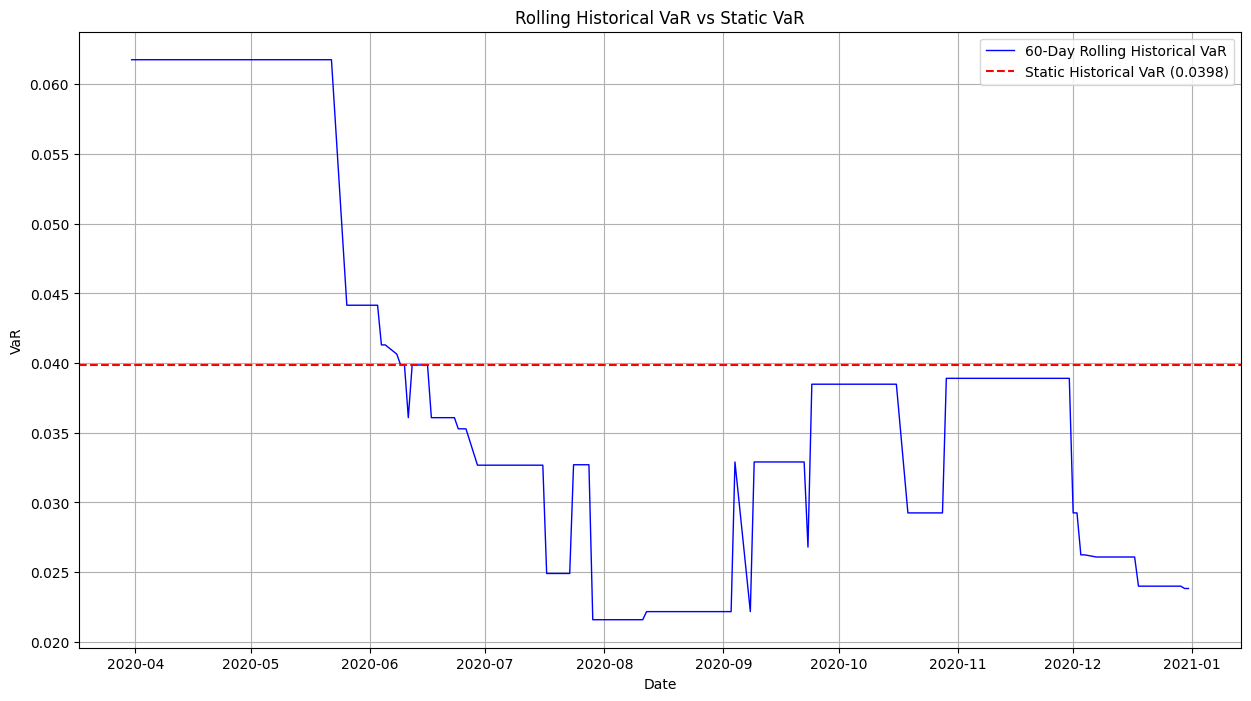

Rolling VaR Statistic:
 Mean Rolling VaR: 0.037798
Max Rolling VaR: 0.061770
Min Rolling VaR: 0.021580


In [38]:
# Step 14: Rolling Historical VaR
#
print("\n" + "="*60)
print("STEP 14: ROLLING HISTORICAL VaR")
print("="*60)

# Calculate 60-day rolling VaR
window = 60
rolling_var = []
dates = []

for i in range(window, len(portfolio_returns)):
    window_returns = portfolio_returns.iloc[i-window:i]
    var_value = -np.percentile(window_returns, 5)
    rolling_var.append(var_value)
    dates.append(portfolio_returns.index[i])

rolling_var_series = pd.Series(rolling_var, index=dates)

# Plot rolling VaR vs static VaR
plt.figure(figsize=(15, 8))
plt.plot(rolling_var_series.index, rolling_var_series.values, 
         label='60-Day Rolling Historical VaR', color='blue', linewidth=1)
plt.axhline(y=var_historical, color='red', linestyle='--', 
            label=f'Static Historical VaR ({var_historical:.4f})')
plt.title('Rolling Historical VaR vs Static VaR')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.legend()
plt.grid(True)
plt.show()

print(f"Rolling VaR Statistic:")
print(f" Mean Rolling VaR: {rolling_var_series.mean():.6f}")
print(f"Max Rolling VaR: {rolling_var_series.max():.6f}")
print(f"Min Rolling VaR: {rolling_var_series.min():.6f}")


In [39]:
# STEP 15: NORMALITY TESTING
print("\n" + "="*50)
print("STEP 15: NORMALITY TESTING")
print("="*50)

# Jarque-Bera test on portfolio returns
jb_stat, jb_pvalue = stats.jarque_bera(portfolio_returns)

print("Jarque-Bera Normality Test:")
print(f"Test Statistic: {jb_stat:.4f}")
print(f"P-value: {jb_pvalue:.6f}")

if jb_pvalue < 0.05:
    print("Result: REJECT normality assumption (p < 0.05)")
    print("Interpretation: portfolio returns do NOT follow a normal distribution")
else:
    print("Result: FAIL TO REJECT normality assumption (p >= 0.05)")
    print("Interpretation: Portfolio returns may follow a normal distribution")

# Additional normality tests
shapiro_stat, shapiro_p = stats.shapiro(portfolio_returns)
print(f"\nShapiro-Wilk Test:")
print(f"Test Statistic: {shapiro_stat:.4f}")
print(f"P-value: {shapiro_p:.6f}")

# STEP 16: HYPOTHESIS TESTING - Is Mean Return Significantly Different from Zero?
print("\n" + "="*50)
print("STEP 16: HYPOTHESIS TESTING")
print("="*50)

# One-sample t-test: H0: μ = 0, H1: μ ≠ 0
t_stat, p_value = stats.ttest_1samp(portfolio_returns, 0)

print("One-Sample t-Test (H0: μ = 0):")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.6f}")

if p_value < 0.05:
    print("Result: REJECT null hypothesis (p < 0.05)")
    print("Interpretation: Mean return is significantly different from zero")
else:
    print("Result: FAIL TO REJECT null hypothesis (p >= 0.05)")
    print("Interpretation: Mean return is not significantly different from zero")


STEP 15: NORMALITY TESTING
Jarque-Bera Normality Test:
Test Statistic: 205.2014
P-value: 0.000000
Result: REJECT normality assumption (p < 0.05)
Interpretation: portfolio returns do NOT follow a normal distribution

Shapiro-Wilk Test:
Test Statistic: 0.9293
P-value: 0.000000

STEP 16: HYPOTHESIS TESTING
One-Sample t-Test (H0: μ = 0):
t-statistic: 1.1151
p-value: 0.265895
Result: FAIL TO REJECT null hypothesis (p >= 0.05)
Interpretation: Mean return is not significantly different from zero


In [46]:
import numpy as np
import pandas as pd
import yfinance as yf

from scipy.stats import norm, t, jarque_bera

def portfolio_summary(stocks, start_date, end_date):
    # ============================
    # DATA DOWNLOAD
    # ============================
    prices = yf.download(stocks, start=start_date, end=end_date)["Close"]
    log_returns = np.log(prices / prices.shift(1)).dropna()

    # ============================
    # PORTFOLIO RETURNS
    # ============================
    weights = np.array([1/len(stocks)] * len(stocks))  # Equal weights
    portfolio_returns = (log_returns * weights).sum(axis=1)
    portfolio_mean = portfolio_returns.mean()
    portfolio_std = portfolio_returns.std()

    # ============================
    # RISK METRICS
    # ============================
    # Value at Risk (95%)
    var_normal = -norm.ppf(0.05, portfolio_mean, portfolio_std)
    df, loc, scale = t.fit(portfolio_returns)
    var_t = -(t.ppf(0.05, df, loc=loc, scale=scale))
    var_historical = -np.percentile(portfolio_returns, 5)

    # Expected Shortfall
    es_historical = -portfolio_returns[portfolio_returns <= -var_historical].mean()
    es_normal = -(portfolio_mean - portfolio_std * norm.pdf(norm.ppf(0.05)) / 0.05)

    # Maximum Drawdown
    cumulative = (1 + portfolio_returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Diversification
    individual_stds = log_returns.std()
    weighted_avg_risk = np.sqrt(np.sum((weights * individual_stds) ** 2))
    diversification_benefit = weighted_avg_risk - portfolio_std

    # Backtesting Exceptions
    exceptions_normal = np.sum(portfolio_returns < -var_normal)

    # Normality Test
    jb_stat, jb_pvalue = jarque_bera(portfolio_returns)

    # ============================
    # FINAL PRINT
    # ============================
    print("=" * 50)
    print("FINAL SUMMARY - PORTFOLIO RISK ASSESSMENT")
    print("=" * 50)

    print(f"Portfolio Composition: {stocks} (Equal weights)")
    print(f"Analysis Period: {pd.to_datetime(start_date).date()} to {pd.to_datetime(end_date).date()}")
    print(f"Total Observations: {len(portfolio_returns)}")

    print("\nKey Risk Metrics:")
    print(f"Daily Mean Return: {portfolio_mean:.6f} ({portfolio_mean*252*100:.2f}% annualized)")
    print(f"Daily Volatility: {portfolio_std:.6f} ({portfolio_std*np.sqrt(252)*100:.2f}% annualized)")

    print("\n95% Value at Risk (1-Day):")
    print(f"Normal Distribution: {var_normal*100:.2f}%")
    print(f"Student's t-Distribution: {var_t*100:.2f}%")
    print(f"Historical: {var_historical*100:.2f}%")

    print("\n95% Expected Shortfall:")
    print(f"Historical: {es_historical*100:.2f}%")
    print(f"Parametric (Normal): {es_normal*100:.2f}%")

    print("\nRisk Assessment:")
    print(f"Maximum Drawdown: {max_drawdown*100:.2f}%")
    print(f"Diversification Benefit: {diversification_benefit:.6f}")

    print("\nModel Validation:")
    print(f"Normal Distribution VAR Exceptions: {exceptions_normal/len(portfolio_returns)*100:.2f}% (Expected: 5.00%)")
    print(f"Returns Follow Normal Distribution: {'NO' if jb_pvalue < 0.05 else 'Possibly'}")

    print("\n" + "=" * 50)
    print("ANALYSIS COMPLETE")
    print("=" * 50)


# ============================
# CALL FUNCTION
# ============================
portfolio_summary(
    stocks=["AAPL", "MSFT", "GOOGL", "AMZN"],
    start_date="2020-01-01",
    end_date="2024-01-01"
)


C:\Users\thaku\AppData\Local\Temp\ipykernel_10160\399535725.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(stocks, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  4 of 4 completed


FINAL SUMMARY - PORTFOLIO RISK ASSESSMENT
Portfolio Composition: ['AAPL', 'MSFT', 'GOOGL', 'AMZN'] (Equal weights)
Analysis Period: 2020-01-01 to 2024-01-01
Total Observations: 1005

Key Risk Metrics:
Daily Mean Return: 0.000756 (19.05% annualized)
Daily Volatility: 0.019062 (30.26% annualized)

95% Value at Risk (1-Day):
Normal Distribution: 3.06%
Student's t-Distribution: 2.80%
Historical: 3.03%

95% Expected Shortfall:
Historical: 4.41%
Parametric (Normal): 3.86%

Risk Assessment:
Maximum Drawdown: -43.98%
Diversification Benefit: -0.008222

Model Validation:
Normal Distribution VAR Exceptions: 4.58% (Expected: 5.00%)
Returns Follow Normal Distribution: NO

ANALYSIS COMPLETE
